In [99]:
from sklearn.datasets import make_circles

In [100]:
n_samples = 1000
noise = 0.02
random_state = 42
X, y = make_circles(n_samples, noise = noise, random_state = random_state)

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

In [102]:
circles = pd.DataFrame({"X0":X[:,0], "X1":X[:,1], "label":y})

In [103]:
circles

,X0,X1,label
0,0.760266,0.223878,1
1,-0.767222,0.145542,1
2,-0.808159,0.148944,1
3,-0.376028,0.703209,1
4,0.440510,-0.897617,0
...,...,...,...
995,0.241536,0.953294,0
996,-0.975298,-0.264479,0
997,-0.141235,-0.801951,1
998,0.675090,-0.754657,0


In [104]:
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

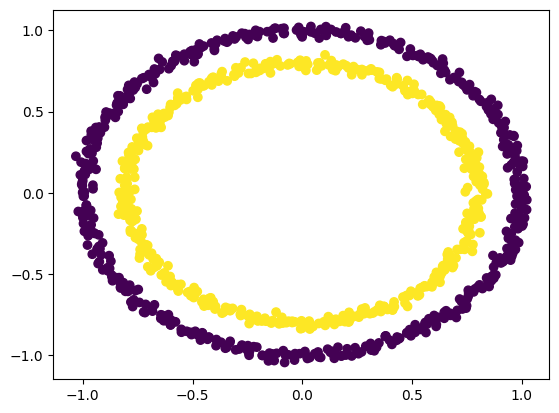

In [105]:
plt.scatter(circles.X0, circles.X1, c = circles.label)
# plt.legend('outer', 'inner')

In [106]:
X.shape, y.shape

((1000, 2), (1000,))

In [107]:
X = torch.from_numpy(X).to(torch.float32)
y = torch.from_numpy(y).to(torch.float32)

In [108]:
X.shape, y.shape

(torch.Size([1000, 2]), torch.Size([1000]))

In [109]:
X_train, y_train = X[:800, :], y[:800]
X_test, y_test = X[800:, :], y[800:]

In [110]:
from sklearn.model_selection import train_test_split # Correct the typo in the module name

In [111]:
X_train, X_test, y_train , y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [112]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [113]:
from torch import nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [114]:
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features = 2, out_features=5)
    self.layer2 = nn.Linear(in_features = 5, out_features=10)
    self.layer3 = nn.Linear(in_features = 10, out_features = 1)
    # self.relu = nn.ReLU()

  def forward(self, x):
    return self.layer3(self.layer2(self.layer1(x)))

model0 = CircleModelV0().to(device)
model0

CircleModelV0(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
)

In [115]:
model_0 = nn.Sequential(
    nn.Linear(in_features = 2, out_features = 5),
    # nn.Linear(in_features = 5, out_features= 10),
    nn.ReLU(),
    nn.Linear(in_features = 5, out_features = 1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): ReLU()
  (2): Linear(in_features=5, out_features=1, bias=True)
)

In [116]:
untrained_preds = model_0(X_test.to(device))

In [117]:
print(f'Number of samples: {len(X_train)}')
print(f'Number of classes: {len(set(y_train))}\n')
print(f'Model outputs:\n{untrained_preds[:10]}')
print(f'Labels:\n{y_test[:10]}')

Number of samples: 800
Number of classes: 800

Model outputs:
tensor([[-0.3692],
        [-0.3671],
        [-0.3442],
        [-0.3839],
        [-0.2443],
        [-0.2449],
        [-0.3030],
        [-0.2737],
        [-0.3505],
        [-0.3648]], grad_fn=<SliceBackward0>)
Labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [118]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = model_0.parameters(), lr = 0.1)

In [119]:
def accuracy_fn(y_pred, y_label):
  correct = torch.eq(y_pred, y_label).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

In [120]:
y = torch.tensor([0, 1, 1, 1, 0])
x = torch.tensor([1, 1, 1, 1, 1])

torch.eq(y, x).sum()

tensor(3)

In [121]:
x = torch.arange(0, 100, 10)
x, x.shape
x =x.squeeze()
x.shape


torch.Size([10])

In [122]:
X_test.dim()

2

In [123]:
X_test.shape

torch.Size([200, 2])

In [124]:
y_logits = model_0(X_test.to(device))
y_logits[:5]

tensor([[-0.3692],
        [-0.3671],
        [-0.3442],
        [-0.3839],
        [-0.2443]], grad_fn=<SliceBackward0>)

In [125]:
y_pred_prob = torch.sigmoid(y_logits)[:5]
y_pred_prob

tensor([[0.4087],
        [0.4092],
        [0.4148],
        [0.4052],
        [0.4392]], grad_fn=<SliceBackward0>)

In [126]:
y_pred = torch.round(y_pred_prob)
y_pred

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], grad_fn=<RoundBackward0>)

In [127]:
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test[:5].to(device))))

In [128]:
torch.eq(y_pred_labels.squeeze(), y_pred.squeeze())

tensor([True, True, True, True, True])

In [129]:
y_pred

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], grad_fn=<RoundBackward0>)

In [130]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [137]:
torch.manual_seed(42)

epoches  = 10000

for epoch in range(epoches):
  model_0.train()

  y_logits = model_0(X_train)
  y_pred = torch.round(torch.sigmoid(y_logits))

  Loss = loss_fn(y_logits.squeeze(), y_train.squeeze())
  acc = accuracy_fn(y_pred.squeeze(), y_train)

  optimizer.zero_grad()
  Loss.backward()
  optimizer.step()

  model_0.eval()
  with torch.inference_mode():
    test_logits = model_0(X_test)
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits.squeeze(), y_test.squeeze())
    test_acc = accuracy_fn(test_pred.squeeze(), y_test)

  if epoch % 100 == 0:
    print(f'Epoch: {epoch} | Loss: {Loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%')

Epoch: 0 | Loss: 0.17325, Accuracy: 99.88% | Test Loss: 0.20483, Test Accuracy: 99.00%
Epoch: 100 | Loss: 0.17147, Accuracy: 99.75% | Test Loss: 0.20348, Test Accuracy: 99.50%
Epoch: 200 | Loss: 0.16993, Accuracy: 99.75% | Test Loss: 0.20213, Test Accuracy: 99.50%
Epoch: 300 | Loss: 0.16847, Accuracy: 99.75% | Test Loss: 0.20076, Test Accuracy: 99.50%
Epoch: 400 | Loss: 0.16704, Accuracy: 99.62% | Test Loss: 0.19919, Test Accuracy: 99.50%
Epoch: 500 | Loss: 0.16567, Accuracy: 99.62% | Test Loss: 0.19778, Test Accuracy: 99.50%
Epoch: 600 | Loss: 0.16434, Accuracy: 99.62% | Test Loss: 0.19646, Test Accuracy: 99.50%
Epoch: 700 | Loss: 0.16304, Accuracy: 99.62% | Test Loss: 0.19517, Test Accuracy: 99.50%
Epoch: 800 | Loss: 0.16176, Accuracy: 99.62% | Test Loss: 0.19390, Test Accuracy: 99.50%
Epoch: 900 | Loss: 0.16051, Accuracy: 99.62% | Test Loss: 0.19265, Test Accuracy: 99.50%
Epoch: 1000 | Loss: 0.15926, Accuracy: 99.62% | Test Loss: 0.19165, Test Accuracy: 99.50%
Epoch: 1100 | Loss: 0.

In [138]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


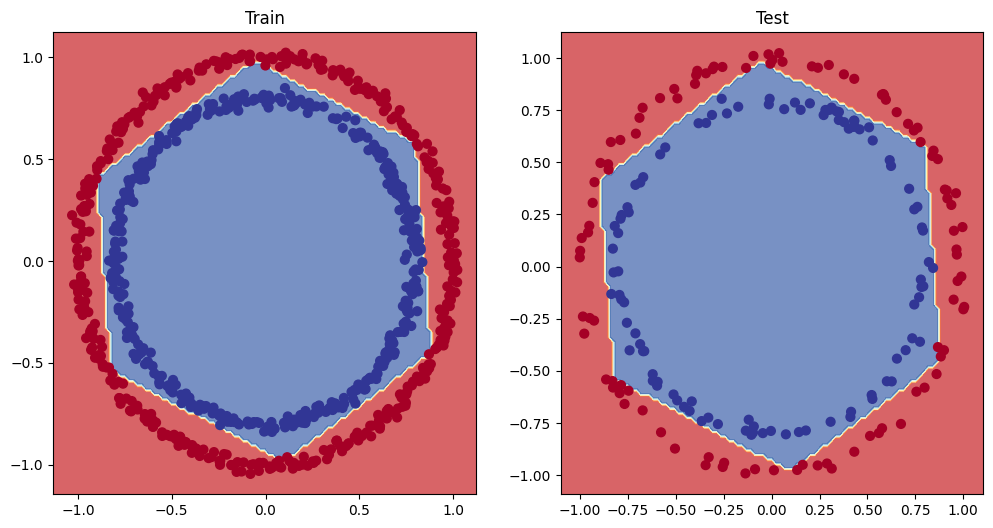

In [139]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

In [134]:
nLossFn = nn.BCEWithLogitsLoss()
nOptimizer = torch.optim.SGD(params = model0.parameters(), lr = 0.1)

In [135]:
torch.manual_seed(42)
epoches = 10000

for epoch in range(epoches):
  model0.train()

  y_logits = model0(X_train.to(device))
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = nLossFn(y_logits.squeeze(), y_train.squeeze())
  acc = accuracy_fn(y_pred.squeeze(), y_train)

  nOptimizer.zero_grad()
  loss.backward()
  nOptimizer.step()
  #GEMNAI please print the epoches
  model_0.eval()
  with torch.inference_mode():
    test_logits = model0(X_test.to(device))
    test_pred = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits.squeeze(), y_test.squeeze())
    test_acc = accuracy_fn(test_pred.squeeze(), y_test)
  if epoch % 100 == 0:
    print(f'Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%')



Epoch: 0 | Loss: 0.70649, Accuracy: 50.00% | Test Loss: 0.70289, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.69323, Accuracy: 49.75% | Test Loss: 0.69410, Test Accuracy: 50.50%
Epoch: 200 | Loss: 0.69300, Accuracy: 50.75% | Test Loss: 0.69456, Test Accuracy: 47.00%
Epoch: 300 | Loss: 0.69298, Accuracy: 51.25% | Test Loss: 0.69469, Test Accuracy: 46.50%
Epoch: 400 | Loss: 0.69298, Accuracy: 50.88% | Test Loss: 0.69471, Test Accuracy: 45.50%
Epoch: 500 | Loss: 0.69298, Accuracy: 51.25% | Test Loss: 0.69470, Test Accuracy: 45.50%
Epoch: 600 | Loss: 0.69298, Accuracy: 51.25% | Test Loss: 0.69470, Test Accuracy: 45.50%
Epoch: 700 | Loss: 0.69298, Accuracy: 51.25% | Test Loss: 0.69469, Test Accuracy: 45.50%
Epoch: 800 | Loss: 0.69298, Accuracy: 51.25% | Test Loss: 0.69469, Test Accuracy: 45.50%
Epoch: 900 | Loss: 0.69298, Accuracy: 51.25% | Test Loss: 0.69469, Test Accuracy: 45.50%
Epoch: 1000 | Loss: 0.69298, Accuracy: 51.25% | Test Loss: 0.69469, Test Accuracy: 45.50%
Epoch: 1100 | Loss: 0.

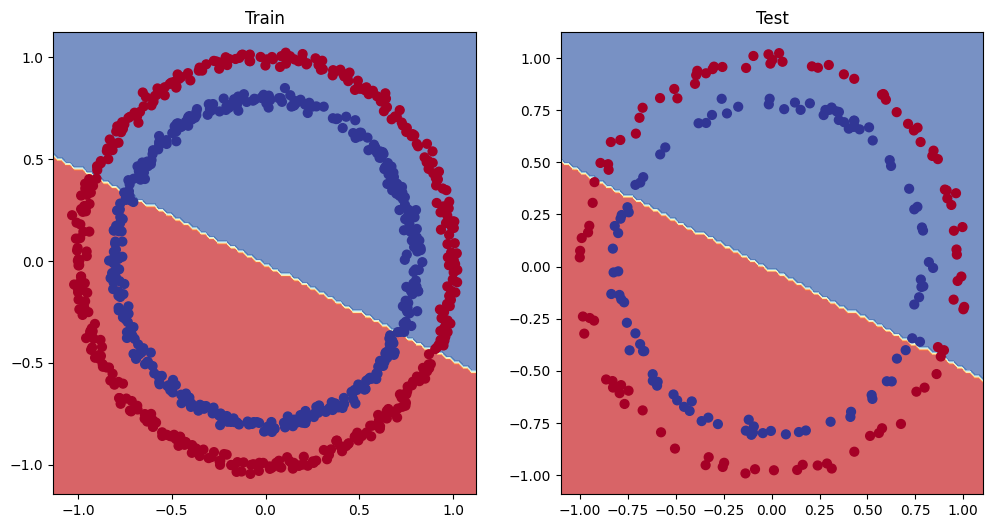

In [136]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model0, X_test, y_test)